In [229]:
import numpy as np
import matplotlib.pyplot as plt

In [274]:
class Graph(object):
    def __init__(self):
        self.list_nodes = []
        self.adj_list = {}
        self.num_edges = 0
    
    def add_node(self,key):
        if key not in self.list_nodes:
            self.list_nodes.append(key)
        self.adj_list[key]={}
        
    def add_edge(self, node1, node2, weight):
        self.num_edges += 1
        try:
            self.adj_list[node1][node2] = weight
        except:
            self.adj_list[node1]={}
            self.adj_list[node1][node2] = weight
        if node1 not in self.list_nodes:
            self.list_nodes.append(node1)
        if node2 not in self.list_nodes:
            self.list_nodes.append(node2)
        
    def print_graph(self):
        for key,value in self.adj_list.items():
            print("node: %s, connected_nodes: %s" %(key, value))
            
    def get_nodes(self):
        return(self.list_nodes)
    
    def get_num_edges(self):
        return(self.num_edges)
    
    def check_edge(self,x):
        if x[1] in self.adj_list[x[0]]:
            return(True)
        else:
            return(False)

In [257]:

## Hit info (timestamp, candidate parent) about a node in a cascade

class THitInfo(object):
    def __init__(self, NId, Parent, Tm):
        self.NId = NId
        self.Parent = Parent
        self.Tm = Tm
        

## Cascade

class TCascade(object):
    def __init__(self):
        self.NIdHitH = {}
        self.CurProb = 0.0
        self.Alpha = 1.0
        self.Model = 0
        self.Eps = 1*10**(-64)
    
    def Len(self):
        return(len(self.NIdHitH))
    
    def GetNode(self, i):
        k=0
        for key in self.NIdHitH.keys():
            if k==i:
                return(key)
            k+=1
    
    def GetParent(self, NId):
        return(self.NIdHitH[NId].Parent)
            
    def GetAlpha(self):
        return(self.Alpha)
    
    def GetTm(self, NId):
        return(self.NIdHitH[NId].Tm)
            
    def Add(self, NId, HitTm):
        self.NIdHitH[NId] = THitInfo(NId, None, HitTm)
        
    def Del(self, NId):
        del self.NIdHitH[NId]
        
    def IsNode(self, NId):
        if NId in self.NIdHitH.keys():
            return(True)
        else:
            return(False)
        
    def TransProb(self, NId1, NId2):
        if (not self.IsNode(NId1)) or (not self.IsNode(NId2)):
            return(self.Eps)
        if (self.GetTm(NId1)>=self.GetTm(NId2)):
            return(self.Eps)
        return(self.Alpha*np.exp(-1*self.Alpha*(float(self.GetTm(NId2))-float(self.GetTm(NId1)))))
    
    def GetProb(self, graph):
        pass
    
    def InitProb(self):
        self.CurProb = np.log(self.Eps)*self.Len()
        for i in range(0,self.Len()):
            self.NIdHitH[self.NIdHitH.keys()[i]].Parent = -1
    
    def UpdateProb(self, N1, N2, boolean):
        if (not self.IsNode(N1)) or (not self.IsNode(N2)):
            return(self.CurProb)
        if (float(self.GetTm(N1))>=float(self.GetTm(N2))):
            return(self.CurProb)
        P1 = np.log(self.TransProb(self.GetParent(N2),N2))
        P2 = np.log(self.TransProb(N1,N2))
        if P1<P2:
            if boolean:
                self.CurProb = self.CurProb - P1 + P2;
                self.NIdHitH[N2].Parent = N1;
            else:
                return(self.CurProb - P1 + P2)
        return(self.CurProb)


## Node info (name and number of cascades)

class TNodeInfo(object):
    def __init__(self, Name, Vol):
        self.Name = Name
        self.Vol = Vol


## Edge info (name and number of cascades)
class TEdgeInfor(object):
    def __init__(self):
        self.Vol = Vol
        self.MarginalGain = MarginalGain
        self.MarginalBound = MarginalBound
        self.MedianTimeDiff = MedianTimeDiff
        self.AverageTimeDiff = AverageTimeDiff
        

## NETINF algorithm class
class TNetInfBs(object):
    def __init__(self):
        self.CascV = []
        self.NodeNmH = {}
        self.EdgeInfoH = {}
        self.EdgeGainV = []
        self.graph = Graph()
        self.GroundTruth = Graph()
        self.CascPerEdge = {}  # To implement localized update
        self.PrecisionRecall = []
        
    def LoadCascadesTxt(self, fname):
        with open(fname, 'r') as ins:
            lines = [i for i in ins]
            i=0
            while lines[i]!="" and lines[i]!='\r\n' :
                self.AddNodeNm(lines[i].split(",")[0], TNodeInfo(lines[i].split(",")[1], 0))
                i+=1
            i+=1
            while i<len(lines) and lines[i]!="" and lines[i]!='\r\n':
                self.AddCasc(lines[i])
                i+=1
                
    def LoadGroundTruthTxt(self, fname):
        with open(fname, 'r') as ins:
            lines = [i for i in ins]
            i=0
            while lines[i]!="" and lines[i]!='\r\n' :
                self.GroundTruth.add_node(lines[i].split(",")[1])
                i+=1
            i+=1
            while i<len(lines) and lines[i]!="" and lines[i]!='\r\n':
#                 print(int(lines[i].split(",")[0]))
                self.GroundTruth.add_edge(lines[i].split(",")[0], lines[i].split(",")[1], 1)
                i+=1
    
    def AddCasc(self, CascStr):
        NIdV = CascStr.split(";")
        C = TCascade()
        for i in range(0,len(NIdV)):
            NId = NIdV[i].split(",")[0]
#             print("Node"+str(NIdV[i].split(",")[0]))
            Tm = NIdV[i].split(",")[1]
#             print("Time"+str(NIdV[i].split(",")[1]))
            if(self.IsNodeNm(NId)):
                self.GetNodeInfo(NId).Vol = self.GetNodeInfo(NId).Vol + 1
                C.Add(NId, Tm)
        self.CascV.append(C)
    
    def GetCascs(self):
        return(len(CascV))
    
    def GetNodes(self):
        pass
    
    def AddNodeNm(self, NId, Info):
        self.NodeNmH[NId] = Info
        
    def GetNodeNm(self, NId):
        return(self.NodeNmH[NId].Name)
    
    def GetNodeInfo(self, NId):
        return(self.NodeNmH[NId])
    
    def IsNodeNm(self, NId):
        if NId in self.NodeNmH.keys():
            return True
        else:
            return False
        
    def Init(self):
        CascPN = {}   # dictionary to store cascades for a particular node
        self.EdgeGainV = []
        self.CascPerEdge = {}
        
        for c in range(0,len(self.CascV)):
            for i in range(0,self.CascV[c].Len()):
                if self.CascV[c].GetNode(i) not in self.graph.get_nodes():
                    self.graph.add_node(self.CascV[c].GetNode(i))
                if self.CascV[c].GetNode(i) not in CascPN:
                    CascPN[self.CascV[c].GetNode(i)] = []
                CascPN[self.CascV[c].GetNode(i)].append(c)
            self.CascV[c].InitProb()
            
        for node in self.graph.get_nodes():
            Cascs = CascPN[node]
            for c in range(0,len(Cascs)):  
                for i in range(0,self.CascV[Cascs[c]].Len()):
                    if self.CascV[Cascs[c]].GetNode(i) == node:
                        continue
                    if self.CascV[Cascs[c]].GetTm(self.CascV[Cascs[c]].GetNode(i)) < self.CascV[Cascs[c]].GetTm(node):
                        pass
                        if tuple((self.CascV[Cascs[c]].GetNode(i), node)) not in self.CascPerEdge:
                            self.EdgeGainV.append([float('inf'),(self.CascV[Cascs[c]].GetNode(i), node)])
                            self.CascPerEdge[tuple((self.CascV[Cascs[c]].GetNode(i), node))] = []
                        self.CascPerEdge[tuple((self.CascV[Cascs[c]].GetNode(i), node))].append(Cascs[c])
    
    def GetAllCascProb(self, EdgeN1, EdgeN2):
        P = 0.0
        if EdgeN1==-1 and EdgeN2==-1:
            for c in range(0,len(self.CascV)):
                P += self.CascV[c].UpdateProb(EdgeN1, EdgeN2, False)
            return(P)
        
        CascsEdge = self.CascPerEdge[EdgeN1, EdgeN2]
        for c in range(0,len(CascsEdge)):
            P += (self.CascV[CascsEdge[c]].UpdateProb(EdgeN1, EdgeN2, False) - self.CascV[CascsEdge[c]].CurProb)
        return(P)
        
    def GetBestEdge(self, CurProb, LastGain, msort, attempts):
        BestE = ()
        KeysV = []
        EdgeGainCopyToSortV = []
        EdgeZero = []
        BestGain = -1 * float('inf')
        BestGainIndex = -1
        
        if msort:
            for i in range(0,min(attempts-1,len(self.EdgeGainV))):
                EdgeGainCopyToSortV.append(self.EdgeGainV[i])
            EdgeGainCopyToSortV.sort()
            i=0
            j=0
            ii=0
            while (ii<len(EdgeGainCopyToSortV)):
                if ( (i+len(EdgeGainCopyToSortV) < len(self.EdgeGainV)) and (EdgeGainCopyToSortV[ii][0] < self.EdgeGainV[i+len(EdgeGainCopyToSortV)][0]) ):
                    self.EdgeGainV[j] = self.EdgeGainV[i+len(EdgeGainCopyToSortV)];
                    i+=1
                else:
                    self.EdgeGainV[j] = EdgeGainCopyToSortV[ii];
                    ii+=1
                j+=1
                
        attempts = 0
        print("---------------------------------Entering best edge---------------------------------")
        print("Length of EdgeGain: "+str(len(self.EdgeGainV)))
        for e in range(0,len(self.EdgeGainV)):
            Edge = self.EdgeGainV[e][1]     #extract edge from main tuple
            
            EProb = self.GetAllCascProb(Edge[0], Edge[1])
            self.EdgeGainV[e][0] = EProb
#             print("Edge:"+str(Edge))
#             print("Eprob:"+str(EProb))
            if self.graph.check_edge(Edge):
#                 print("Edge already present")
                continue
            if BestGain < EProb:
                BestGain = EProb;
                BestGainIndex = e;
                BestE = Edge;
                
            attempts += 1
            
            if not self.graph.check_edge(Edge):
                if EProb == 0:
                    EdgeZero.append(e)
        
#             if e+1 == len(self.EdgeGainV) or BestGain >= self.EdgeGainV[e+1][0]:
            if e+1 == len(self.EdgeGainV):
                print("End of the insertion")
                print("Length of EdgeZero: "+str(len(EdgeZero)))
                CurProb += BestGain
                if BestGain==0:
                    return(-1,-1)
                self.EdgeGainV.pop(BestGainIndex)
                for i in range(len(EdgeZero)-1,-1,-1):
                    if EdgeZero[i]>BestGainIndex:
                        self.EdgeGainV.pop(EdgeZero[i]-1)
                    else:
                        self.EdgeGainV.pop(EdgeZero[i])
                        
                if len(EdgeZero)>2:
                    attempts -= (len(EdgeZero)-1)
            
                msort = attempts>1
                LastGain = BestGain
                return(BestE)
        return(-1,-1)
        
    def GetBound(self):
        pass
    
    def GreedyOpt(self, MxEdges):
        CurProb = self.GetAllCascProb(-1,-1)
        LastGain = float('inf')
        attempts = 0
        msort = False
        
        for k in range(0,MxEdges):
            if len(self.EdgeGainV) > 0:
                prev = CurProb
                BestE = self.GetBestEdge(CurProb, LastGain, msort, attempts)
                if BestE == (-1,-1):
                    break
                print(BestE)                                         
                precision = 0
                recall = 0
                if(len(self.PrecisionRecall)>1):
                    precision = self.PrecisionRecall[len(self.PrecisionRecall)-1][1]
                    recall = self.PrecisionRecall[len(self.PrecisionRecall)-1][0]
                if self.GroundTruth.check_edge(BestE):
                    recall += 1
                else:
                    precision += 1
                self.PrecisionRecall.append([recall, precision])
                                          
                self.graph.add_edge(BestE[0],BestE[1],1)
                CascsEdge = self.CascPerEdge[BestE]
                for c in range(0,len(CascsEdge)):
                    self.CascV[CascsEdge[c]].UpdateProb(BestE[0], BestE[1], True)
                
        for i in range(0,len(self.PrecisionRecall)):
            self.PrecisionRecall[i][1] = 1.0 - (self.PrecisionRecall[i][1]/(self.PrecisionRecall[i][1]+self.PrecisionRecall[i][0]))
            self.PrecisionRecall[i][0] =  (1.0 * self.PrecisionRecall[i][0] )/ self.GroundTruth.get_num_edges()
            print("Precision: "+str(self.PrecisionRecall[i][1]))
            print("Recall: "+str(self.PrecisionRecall[i][0]))

In [275]:
NIB = TNetInfBs()
NIB.LoadCascadesTxt('/Users/rahuldhakecha/coursesfall2017/IS/netinf/example-cascades.txt')
NIB.LoadGroundTruthTxt('/Users/rahuldhakecha/coursesfall2017/IS/netinf/example-network.txt')
NIB.Init()
NIB.GreedyOpt(500)

---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 127781
End of the insertion
Length of EdgeZero: 4335
('263', '479')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 123445
End of the insertion
Length of EdgeZero: 269
('15', '27')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 123175
End of the insertion
Length of EdgeZero: 52
('418', '263')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 123122
End of the insertion
Length of EdgeZero: 44
('263', '59')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 123077
End of the insertion
Length of EdgeZero: 283
('263', '469')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 122793
End of the insertion
Length of E

End of the insertion
Length of EdgeZero: 319
('408', '472')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 117364
End of the insertion
Length of EdgeZero: 304
('148', '404')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 117059
End of the insertion
Length of EdgeZero: 102
('262', '103')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 116956
End of the insertion
Length of EdgeZero: 159
('363', '238')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 116796
End of the insertion
Length of EdgeZero: 274
('21', '336')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 116521
End of the insertion
Length of EdgeZero: 135
('256', '47')
---------------------------------Entering best edge-------------------------------

End of the insertion
Length of EdgeZero: 88
('177', '307')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 110541
End of the insertion
Length of EdgeZero: 229
('471', '55')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 110311
End of the insertion
Length of EdgeZero: 29
('21', '379')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 110281
End of the insertion
Length of EdgeZero: 28
('428', '36')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 110252
End of the insertion
Length of EdgeZero: 24
('392', '136')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 110227
End of the insertion
Length of EdgeZero: 259
('503', '247')
---------------------------------Entering best edge---------------------------------
Le

End of the insertion
Length of EdgeZero: 132
('278', '400')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 105490
End of the insertion
Length of EdgeZero: 217
('317', '17')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 105272
End of the insertion
Length of EdgeZero: 234
('243', '478')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 105037
End of the insertion
Length of EdgeZero: 101
('317', '369')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 104935
End of the insertion
Length of EdgeZero: 146
('414', '13')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 104788
End of the insertion
Length of EdgeZero: 245
('329', '425')
---------------------------------Entering best edge-------------------------------

End of the insertion
Length of EdgeZero: 76
('267', '412')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 100011
End of the insertion
Length of EdgeZero: 283
('103', '39')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 99727
End of the insertion
Length of EdgeZero: 112
('47', '57')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 99614
End of the insertion
Length of EdgeZero: 265
('228', '99')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 99348
End of the insertion
Length of EdgeZero: 79
('274', '26')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 99268
End of the insertion
Length of EdgeZero: 253
('238', '366')
---------------------------------Entering best edge---------------------------------
Length

End of the insertion
Length of EdgeZero: 107
('164', '4')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 93501
End of the insertion
Length of EdgeZero: 52
('129', '187')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 93448
End of the insertion
Length of EdgeZero: 65
('357', '373')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 93382
End of the insertion
Length of EdgeZero: 150
('287', '150')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 93231
End of the insertion
Length of EdgeZero: 72
('380', '483')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 93158
End of the insertion
Length of EdgeZero: 60
('238', '234')
---------------------------------Entering best edge---------------------------------
Length

End of the insertion
Length of EdgeZero: 109
('478', '506')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 87587
End of the insertion
Length of EdgeZero: 80
('333', '108')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 87506
End of the insertion
Length of EdgeZero: 241
('233', '139')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 87264
End of the insertion
Length of EdgeZero: 232
('434', '250')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 87031
End of the insertion
Length of EdgeZero: 204
('483', '227')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 86826
End of the insertion
Length of EdgeZero: 96
('234', '113')
---------------------------------Entering best edge---------------------------------
Le

End of the insertion
Length of EdgeZero: 140
('30', '7')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 80606
End of the insertion
Length of EdgeZero: 166
('140', '285')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 80439
End of the insertion
Length of EdgeZero: 160
('483', '49')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 80278
End of the insertion
Length of EdgeZero: 70
('42', '306')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 80207
End of the insertion
Length of EdgeZero: 35
('262', '332')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 80171
End of the insertion
Length of EdgeZero: 42
('364', '416')
---------------------------------Entering best edge---------------------------------
Length o

End of the insertion
Length of EdgeZero: 229
('224', '182')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 75087
End of the insertion
Length of EdgeZero: 87
('57', '171')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 74999
End of the insertion
Length of EdgeZero: 127
('132', '4')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 74871
End of the insertion
Length of EdgeZero: 43
('79', '386')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 74827
End of the insertion
Length of EdgeZero: 44
('508', '239')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 74782
End of the insertion
Length of EdgeZero: 77
('114', '152')
---------------------------------Entering best edge---------------------------------
Length o

End of the insertion
Length of EdgeZero: 111
('116', '25')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 69856
End of the insertion
Length of EdgeZero: 198
('31', '83')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 69657
End of the insertion
Length of EdgeZero: 72
('234', '280')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 69584
End of the insertion
Length of EdgeZero: 118
('448', '72')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 69465
End of the insertion
Length of EdgeZero: 133
('66', '476')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 69331
End of the insertion
Length of EdgeZero: 103
('63', '47')
---------------------------------Entering best edge---------------------------------
Length o

End of the insertion
Length of EdgeZero: 207
('396', '508')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 63560
End of the insertion
Length of EdgeZero: 109
('20', '148')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 63450
End of the insertion
Length of EdgeZero: 5
('73', '11')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 63444
End of the insertion
Length of EdgeZero: 156
('455', '340')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 63287
End of the insertion
Length of EdgeZero: 45
('311', '286')
---------------------------------Entering best edge---------------------------------
Length of EdgeGain: 63241
End of the insertion
Length of EdgeZero: 163
('354', '146')
---------------------------------Entering best edge---------------------------------
Length

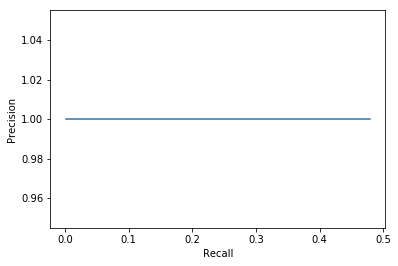

In [278]:
y=[i[1] for i in NIB.PrecisionRecall]
x=[i[0] for i in NIB.PrecisionRecall]
plt.plot(x,y)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()